# Appendix: Distances between clean and adversarial images

In [2]:
import os
import numpy as np
import torch
import lpips
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
# Path to your ORIGINAL clean images
CLEAN_DIR = "../adv_VOC_YOLO_eps_0.00/images/val"

# The parent folder containing the "adv_VOC_YOLO_eps_..." folders
PERTURBED_PARENT_DIR = "../"

EPSILONS = [0.00, 0.02, 0.04, 0.06, 0.08, 0.1, 0.13, 0.17, 0.2]

EXTENSIONS = (".png", ".jpg", ".jpeg")


def get_perturbed_path(base_dir, eps):
    # This turns 0.1 into "0.10", 0.02 into "0.02",...
    folder_name = "adv_VOC_YOLO_eps_{:.2f}".format(eps)

    return os.path.join(base_dir, folder_name, "images", "val")


# Initialize LPIPS (AlexNet)
loss_fn_lpips = lpips.LPIPS(net="alex", verbose=False)

lpips_preprocess = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


def get_linf(img_clean_np, img_pert_np):
    diff = np.abs(img_clean_np / 255.0 - img_pert_np / 255.0)
    return np.max(diff)


def process_datasets():
    results = {}

    clean_files = sorted(
        [f for f in os.listdir(CLEAN_DIR) if f.lower().endswith(EXTENSIONS)]
    )
    print(f"Found {len(clean_files)} clean images. Starting evaluation.\n")

    for eps in EPSILONS:
        pert_dir = get_perturbed_path(PERTURBED_PARENT_DIR, eps)

        if not os.path.exists(pert_dir):
            print(f"Warning: Directory not found for eps={eps}:")
            print(f"   Looking for: {pert_dir}")
            continue

        print(
            f"Processing Epsilon {eps} in {os.path.basename(os.path.dirname(os.path.dirname(pert_dir)))}..."
        )

        b_lpips, b_ssim, b_linf = [], [], []

        for fname in clean_files:
            clean_path = os.path.join(CLEAN_DIR, fname)
            pert_path = os.path.join(pert_dir, fname)

            if not os.path.exists(pert_path):
                continue

            try:
                img_c = Image.open(clean_path).convert("RGB")
                img_p = Image.open(pert_path).convert("RGB")
            except Exception as e:
                print(f"Error reading {fname}: {e}")
                continue

            # 1. LPIPS
            t_c = lpips_preprocess(img_c).unsqueeze(0)
            t_p = lpips_preprocess(img_p).unsqueeze(0)
            with torch.no_grad():
                val_lpips = loss_fn_lpips(t_c, t_p).item()

            np_c = np.array(img_c)
            np_p = np.array(img_p)

            # 2. SSIM
            try:
                val_ssim = ssim(np_c, np_p, channel_axis=2, data_range=255)
            except TypeError:
                val_ssim = ssim(np_c, np_p, multichannel=True, data_range=255)

            # 3. Linf
            val_linf = get_linf(np_c, np_p)

            b_lpips.append(val_lpips)
            b_ssim.append(val_ssim)
            b_linf.append(val_linf)

        results[eps] = {"lpips": b_lpips, "ssim": b_ssim, "linf": b_linf}

    return results


raw_data = process_datasets()

Found 4952 clean images. Starting evaluation.

Processing Epsilon 0.0 in adv_VOC_YOLO_eps_0.00...
Processing Epsilon 0.02 in adv_VOC_YOLO_eps_0.02...
Processing Epsilon 0.04 in adv_VOC_YOLO_eps_0.04...
Processing Epsilon 0.06 in adv_VOC_YOLO_eps_0.06...
Processing Epsilon 0.08 in adv_VOC_YOLO_eps_0.08...
Processing Epsilon 0.1 in adv_VOC_YOLO_eps_0.10...
Processing Epsilon 0.13 in adv_VOC_YOLO_eps_0.13...
Processing Epsilon 0.17 in adv_VOC_YOLO_eps_0.17...
Processing Epsilon 0.2 in adv_VOC_YOLO_eps_0.20...


MEAN METRICS vs PERTURBATION BUDGET


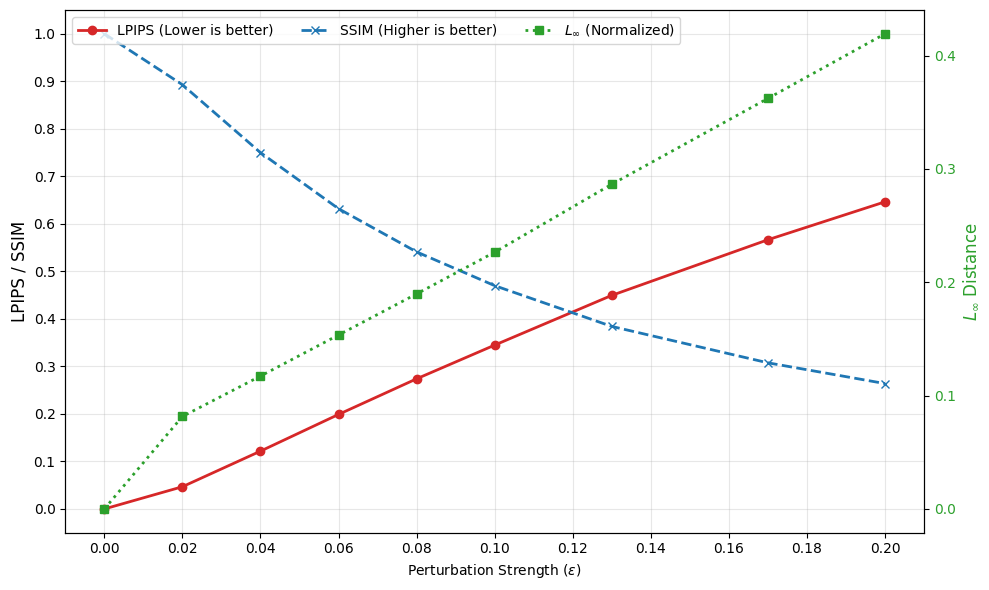

WORST-CASE METRICS vs PERTURBATION BUDGET


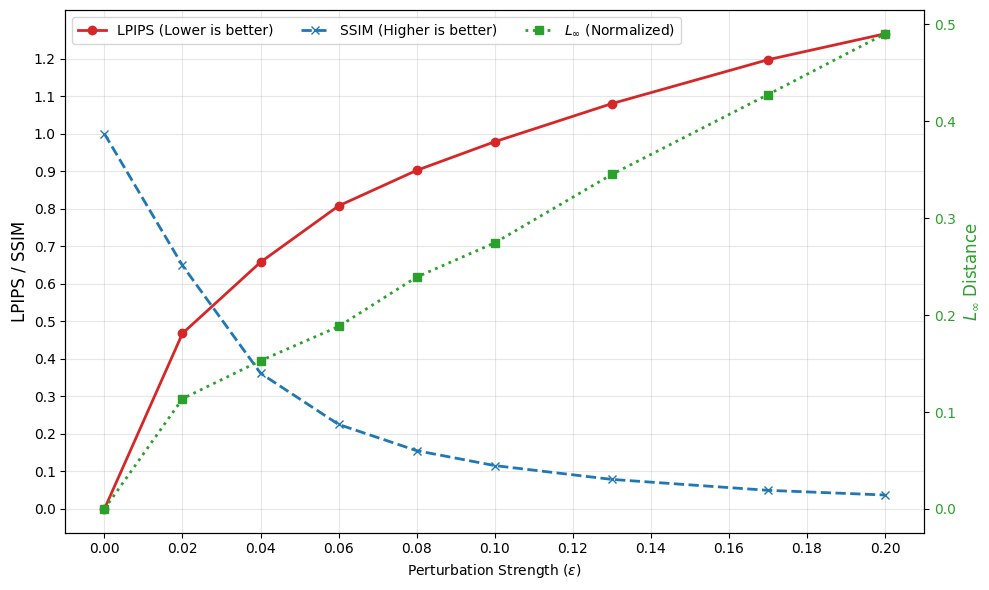

In [6]:
def plot_metrics(data, mode="mean"):
    budgets = sorted(data.keys())
    y_lpips, y_ssim, y_linf = [], [], []
    valid_budgets = []

    for b in budgets:
        vals = data[b]
        if not vals["lpips"]:
            continue

        valid_budgets.append(b)

        if mode == "mean":
            y_lpips.append(np.mean(vals["lpips"]))
            y_ssim.append(np.mean(vals["ssim"]))
            y_linf.append(np.mean(vals["linf"]))
            title_text = "Mean Metrics vs Perturbation Budget"
        elif mode == "worst":
            y_lpips.append(np.max(vals["lpips"]))
            y_ssim.append(np.min(vals["ssim"]))
            y_linf.append(np.max(vals["linf"]))
            title_text = "Worst-Case Metrics vs Perturbation Budget"

    if not valid_budgets:
        print(f"No valid data to plot for mode {mode}")
        return

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel("Perturbation Strength ($\\epsilon$)")
    ax1.set_ylabel("LPIPS / SSIM", color="black", fontsize=12)

    l1 = ax1.plot(
        valid_budgets,
        y_lpips,
        color="tab:red",
        marker="o",
        label="LPIPS (Lower is better)",
        linewidth=2,
    )
    l2 = ax1.plot(
        valid_budgets,
        y_ssim,
        color="tab:blue",
        marker="x",
        linestyle="--",
        label="SSIM (Higher is better)",
        linewidth=2,
    )

    ax1.tick_params(axis="y", labelcolor="black")
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(valid_budgets)

    ax2 = ax1.twinx()
    color_r = "tab:green"
    ax2.set_ylabel(r"$L_\infty$ Distance", color=color_r, fontsize=12)
    l3 = ax2.plot(
        valid_budgets,
        y_linf,
        color=color_r,
        marker="s",
        linestyle=":",
        label=r"$L_\infty$ (Normalized)",
        linewidth=2,
    )
    ax2.tick_params(axis="y", labelcolor=color_r)

    lines = l1 + l2 + l3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, ncol=3, loc="upper left")
    ax1.set_xticks(np.arange(0, 0.22, 0.02))
    ax1.set_yticks(np.arange(0, max(max(y_lpips), 1.1), 0.1))

    # plt.title(title_text, y=1.2, fontsize=14)
    plt.tight_layout()
    plt.show()


if raw_data:
    print("MEAN METRICS vs PERTURBATION BUDGET")
    plot_metrics(raw_data, mode="mean")
    print("WORST-CASE METRICS vs PERTURBATION BUDGET")
    plot_metrics(raw_data, mode="worst")
else:
    print("No data was processed.")